## Problem definition
"Knowing from a training set of samples listing passengers who survived or did not survive the Titanic disaster, can our model determine based on a given test dataset not containing the survival information, if these passengers in the test dataset survived or not."

Highlights to note:
- On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. Translated 32% survival rate.
- One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew.
- Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

## Set-up

In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras.regularizers import L2

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

## Retrieving data

In [195]:
training = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(training.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [196]:
# Preview of the data
training.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Features with Categorical Values?**
- Survived, Sex, Ticket, Embarked, Pclass

**Features with Continuous Values?** 
- PassengerId, Age, SibSp, Parch, Fare

**Features with Mixed Data Types?**
- Cabin, Ticket

Categorical values may have to be converted to numberical values

## Training Set Information

In [197]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**Features with NaN values**
- Cabin and Age both have incomplete datasets filled with NaN values, of which has to be dealt with
- Age has 177 empty values while Cabin has 687 empty values

**DataType of Features**
- 7 features with integers or floats.
- 5 features are strings.

## Training Set Statistics

**Distribution of Numerical Features**

Early insights that determine if training set is representative of the problem.

- 38% Survival Rate, similar to the actual survival rate of 32%.
- Number of passengers in the training set is 891, representing 40% of the actual number of people on board.
- Most passengers did not come with children or parents (>= 78%)
- ~31% of passengers had a sibling or a spouse.
- Elderly Passengers (Age 65-80) make up only 1% of passengers
- Fares vary widely, with the highest being $512

In [198]:
training.describe()
# Parch percentiles=[0.75, 0.78]
# SibSp percentiles=[0.68, 0.69]
# Fare and Age percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99]

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**Distribution of Categorical Features**
- All names were unique
- There were only 2 genders, with 65% being male (577/891)
- Cabins could have been shared by passengers due to duplicate values
- There were 210 duplicate ticket numbers
- S port was used by 72.5% of passengers (644 out of 889 embarked data points)

In [199]:
# Show stats for objects only
training.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


## Assumptions
The following assumptions are derived from the above data analysis as well as intuition and knowledge of the situation. We aim to validate them before proceeding further.

**Correlation**

Test early for correlation between features and Survival. 

**Completing**
1. Age feature is correlated to survival and should be completed.
2. Embarked feature may be correlated to survival and should be completed.

**Correcting**
1. Due to the number of duplicate tickets and its lack of relevance to survival, it should be removed.
2. Cabin feature has too many missing values and may be removed.
3. PassengerID has no relation to survival and may be dropped.
4. Fare price has no relation to survival and may be dropped. 

**Creating**
1. Creation of new feature 'Family' by combining Parch and SibSp
2. Creation of 'Age Bands', a ordinal categorical feature instead of a continuous categorical feature.

**Classifying**

Adding of assumptions based on problem description.

1. Females have a higher survival rate
2. Children under a certain age have a higher survival rate
3. Upper-class passengers have a higher survival rate

## Analysis of Numerical Features by Correlation

### Heatmap of Correlation 

Represents the correlation between survival and non-object type features.

#### Assumptions Checked

**Reject**:
1. Age feature is correlated to survival and should be completed. Age has a low correlation to survival here and should be removed.
2. Fare price has no relation to survival and may be dropped. Fare price has shown to have some correlation with survival here and should be kept.
2. Creation of new feature 'Family' by combining Parch and SibSp. Both features have low correlation to survival.


**Accept**:
1. PassengerID has no relation to survival and may be dropped.

**In Consideration**
1. Upper-class passengers have a higher survival rate. There has been some correlation between class and survival rate


**Moving Forward**
1. Remove Age and Passenger ID.
2. Keep Fare and Pclass as features
3. Further test if upper-class Passengers have higher survival rate
4. Feature engineer Parch, SibSp 

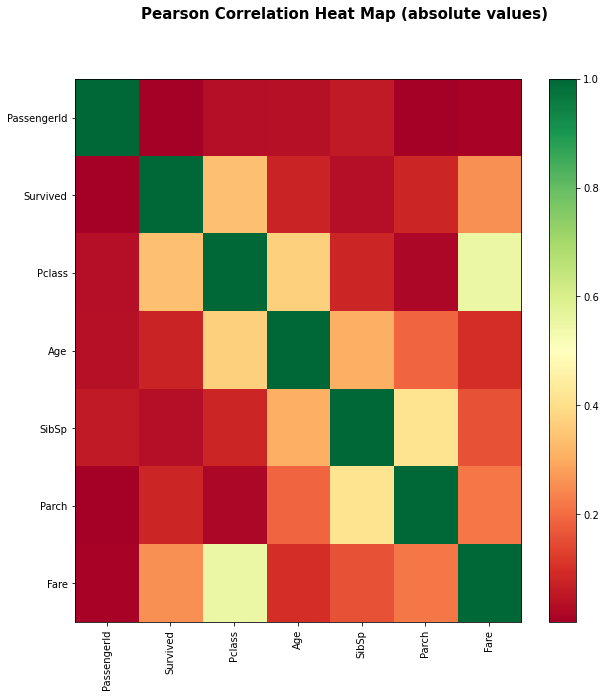

In [200]:
def correlation_matrix(df, is_plot=False):
    
    # Get feature correlations and transform to dataframe
    correlated = df.corr(method='pearson')

    # Convert to abolute values
    abs_correlated = np.abs(correlated) 

    if is_plot:
        plt.figure(figsize=(10, 10))
        plt.imshow(abs_correlated, cmap='RdYlGn', interpolation='none', aspect='auto')
        plt.colorbar()
        plt.xticks(range(len(abs_correlated)), abs_correlated.columns, rotation='vertical')
        plt.yticks(range(len(abs_correlated)), abs_correlated.columns);
        plt.suptitle('Pearson Correlation Heat Map (absolute values)', fontsize=15, fontweight='bold')
        plt.show()

    return correlated, abs_correlated

# Build the correlation matrix for the training data
train_corr, train_abs_corr = correlation_matrix(training, is_plot=True)  

In [201]:
MIN_CORR = 0.1
survived_corr = train_abs_corr['Survived']

# Sort out low correlation features
low_corr = survived_corr[survived_corr < MIN_CORR]
print(f"{len(low_corr)} features with low correlation to survival")
for i, v in enumerate(low_corr):
    print(f"{i+1}: {np.round(v, 4)} {low_corr.index[i]}")

    # Sort out high correlation features
high_corr = survived_corr[survived_corr >= MIN_CORR]
print(f"\n{len(high_corr)} features with correlation >= 0.1")
for i, v in enumerate(high_corr[1:]):
    print(f"{i+1}: {np.round(v, 4)} {high_corr.index[i+1]}")

4 features with low correlation to survival
1: 0.005 PassengerId
2: 0.0772 Age
3: 0.0353 SibSp
4: 0.0816 Parch

3 features with correlation >= 0.1
1: 0.3385 Pclass
2: 0.2573 Fare


## Analysis by Pivoting Features

Here, we continue confirming our assumptions and observations by pivoting features against each other. We can only do this for features with no empty values, and target categorical features here such as Sex, Pclass and Embarked.

**Pclass**: Upper-class Passengers have a higher survival rate of ~63%, confirming our assumption.

**Sex**: Females have a much higher survival rate of 74% as compared to males, confirming our assumption.

**Embarked**: Passengers that embarked from C had higher survival rates.

**Conclusion**: We keep Sex, Pclass and Embarked in our model.

In [202]:
# Pivoting Pclass against Survival
training[['Pclass', 'Survived']].groupby(["Pclass"], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [203]:
# Pivoting Sex against Survival
training[['Sex', 'Survived']].groupby(["Sex"], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [204]:
# Pivoting Embarked against Survival
training[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


## Data Wrangling
Now that we have confirmed our observations and assumptions, we can start modifying features to achieve our goals of correcting and completing.

### Correcting by dropping features
Here we remove features that we deemed to have little to no correlation with survival. This includes Age, Passenger ID, Parch, SibSp, ticket, and cabin.

In [205]:
print(f"Training before correction: {training.shape}")
print(f"Test before correction: {test.shape}")

new_train = training.drop(["Name", "Age", "PassengerId", "Parch", "SibSp", "Ticket", "Cabin"], axis=1)
new_test = test.drop(["Name", "Age", "PassengerId", "Parch", "SibSp", "Ticket", "Cabin"], axis=1)

# Split training set into features X_train and target Y_train
X_train = new_train.drop(["Survived"], axis=1)
y_train = new_train["Survived"]

print(f"Training after correction: {X_train.shape}")
print(f"Test after correction: {new_test.shape}")

X_train

Training before correction: (891, 12)
Test before correction: (418, 11)
Training after correction: (891, 4)
Test after correction: (418, 4)


,Pclass,Sex,Fare,Embarked
0,3,male,7.2500,S
1,1,female,71.2833,C
2,3,female,7.9250,S
3,1,female,53.1000,S
4,3,male,8.0500,S
...,...,...,...,...
886,2,male,13.0000,S
887,1,female,30.0000,S
888,3,female,23.4500,S
889,1,male,30.0000,C


### Converting catgeorical features
We convert categorical features which contains strings into numerical features.

We begim by converting male to 0 and female to 1

In [206]:
combine = [X_train, new_test]

for df in combine:
    df['Sex'] = df['Sex'].map({'female': 1, 'male': 0}).astype(int)
    
X_train

,Pclass,Sex,Fare,Embarked
0,3,0,7.2500,S
1,1,1,71.2833,C
2,3,1,7.9250,S
3,1,1,53.1000,S
4,3,0,8.0500,S
...,...,...,...,...
886,2,0,13.0000,S
887,1,1,30.0000,S
888,3,1,23.4500,S
889,1,0,30.0000,C


### Completing and converting categorical feature
Here, we fill up empty data points in our dataset. This is solely pertaining to the Embarked feature that has 2 missing values, of which we will fill using the most frequent port as seen from Training Information, port S.

We then convert it to a numeric feature, whereby C is 1, Q is 2 and S is 0.

In [207]:
for df in combine:
    df['Embarked'] = df['Embarked'].fillna('S')

    
X_train['Embarked']

0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: object

In [208]:
for df in combine:
     df['Embarked'] = df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [209]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    int64  
 2   Fare      891 non-null    float64
 3   Embarked  891 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 28.0 KB


## Modelling and Predicting
The problem at hand is a classificiation problem to determine whether a passenger will survive based on a given set of features. As we have both features and ground truth labels to determine whether a passenger survived or not, we narrow down our possible machine learning algorithms to:

- Neural Network with Sigmoid Activation
- Logistic Regression
- Boosted Trees

Cost will be measured as the fraction of incorrect predictions. We will test all 5 algorithms and select the one with the lowest cost

### Neural Network

For optimization, output output layer uses a linear activation but loss function is set to BinaryCrossentropy.

In [210]:
# Initiliaze model with layers
neural_model = Sequential([
            Dense(units=50, activation='relu', name='L1', kernel_regularizer=L2(0.2)),
            Dense(units=15, activation='relu', name='L2', kernel_regularizer=L2(0.2)),
            Dense(units=1, activation='linear', name='L3', kernel_regularizer=L2(0.2))
          ])

neural_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.03))

neural_model.fit(X_train, y_train, epochs=50)

Epoch 1/50
 9/28 [========>.....................] - ETA: 0s - loss: 4.2429

2022-07-10 20:54:36.701819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 0s 7ms/step - loss: 2.4567
Epoch 2/50
28/28 [==============================] - 0s 5ms/step - loss: 0.8293
Epoch 3/50
28/28 [==============================] - 0s 5ms/step - loss: 0.6872
Epoch 4/50
28/28 [==============================] - 0s 5ms/step - loss: 0.6675
Epoch 5/50
28/28 [==============================] - 0s 5ms/step - loss: 0.6609
Epoch 6/50
28/28 [==============================] - 0s 5ms/step - loss: 0.6612
Epoch 7/50
28/28 [==============================] - 0s 5ms/step - loss: 0.6606
Epoch 8/50
28/28 [==============================] - 0s 6ms/step - loss: 0.6594
Epoch 9/50
28/28 [==============================] - 0s 5ms/step - loss: 0.6616
Epoch 10/50
28/28 [==============================] - 0s 5ms/step - loss: 0.6596
Epoch 11/50
28/28 [==============================] - 0s 6ms/step - loss: 0.6613
Epoch 12/50
28/28 [==============================] - 0s 5ms/step - loss: 0.6608
Epoch 13/50
28/28 [==============================] - 0s 5ms/

In [211]:
y_train_np = y_train.to_numpy() 
y_train_np = y_train_np.reshape((-1, 1))

In [212]:
neural_predictions = neural_model.predict(Xn)

# Convert to Sigmoid values
neural_yhat = tf.nn.sigmoid(neural_predictions).numpy()

# Set threshold
neural_yhat = (neural_yhat >= 0.5).astype(int)

# Calculate training error
neural_error = len(neural_yhat[neural_yhat!=y_train_np]) / len(y_train_np)
print(f"The training error for Neural network is {neural_error}")

28/28 [==============================] - 0s 2ms/step
The training error for Neural network is 0.3838383838383838


2022-07-10 20:54:44.151129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Logistic Regression

In [213]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
log_predictions = logreg.predict(Xn)

log_error = len(log_predictions[log_predictions!=y_train.to_numpy()]) / len(y_train)
print(f"The training error for Logistic Regression is {log_error}")

The training error for Logistic Regression is 0.22334455667789002


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### Boosted Trees

In [214]:
tree = XGBClassifier()
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_train)

log_error = len(tree_pred[tree_pred!=y_train.to_numpy()]) / len(y_train)
print(f"The training error for Boosted Trees is {log_error}")

The training error for Boosted Trees is 0.10101010101010101


**Conclusion for model selection**
We ultimately pick Boosted Trees as the most appropriate model due to it having the lowest training error out of the 3 models. However, further diagnosis could have been done on the Neural Network and Logistic Regression such as Bias/Variance Analysis in order to better fit the model.

## Diagnosis of Model

Currently, the model has a score of 0.76555 on Kaggle, meaning that our test error is around 0.24. That is ~2.5x the training error and might hint that our model is currently overfit. There are a few methods we can consider to diagnose this problem

1. Increasing the data set
2. Decrease number of features
3. Increase regularisation

For Trees, we can consider options 1 and 2, but there is insufficient data to increase the training data set. As such, we can instead improve the Fare feature by converting it from a continuous value feature to a ranged one.

As the Fare feature has 891 data points, we take intervals of 34 and check for the information gain of the current range. The highest information gain will then become a new feature.

**Select Fare Range**: Fare <= 52
- This however has the limitation of being measured at the root node.
- if Fare <= 52, 0. Else, 1.


In [217]:
X_train["Fare"].describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99])

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
10%        7.550000
20%        7.854200
30%        8.050000
40%       10.500000
50%       14.454200
60%       21.679200
70%       27.000000
80%       39.687500
90%       77.958300
99%      249.006220
max      512.329200
Name: Fare, dtype: float64

In [218]:
# Calculate entrop at a node
def entropy(y):
    entropy = 0
    
    # If empty, return 0
    if len(y) == 0:
        return 0 
    
    # Fraction of positive labels
    p1 = len(y[y==1]) / len(y)
    
    
    if p1 != 0 and p1 != 1:
        entropy = - p1 * np.log2(p1) - (1 - p1) * np.log2(1 - p1)
        
    else:
        entropy = 0
    
    return entropy    

# Splitting a node into two nodes based on a range 
def split(X, node_indices, value):
    left = []
    right = []
    
    for i in node_indices:
        if X[i] <= value:
            left.append(i)
            
        else:
            right.append(i)
            
    return left, right

# Calculate info gain at a node
def infogain(X, y, node_indices, value):
    left, right = split(X, node_indices, value)
    
    X_node, y_node = X[node_indices], y[node_indices]
    X_left, y_left = X[left], y[left]
    X_right, y_right = X[right], y[right]
    
    info_gain = 0
    
    # Compute weights
    left_weight = len(y_left) / len(y_node)
    right_weight = len(y_right) / len(y_node)
    
    # Compute weighted entropy for both nodes
    left_ent = left_weight * entropy(y_left)
    right_ent = right_weight * entropy(y_right)
    
    # Compute info gain
    info_gain = entropy(y_node) - (left_ent + right_ent)
    
    return info_gain
    

In [219]:
# Evaluating each range of value's information gain
fare = X_train['Fare'].to_numpy().reshape(-1, 1)
y_fare = y_train.to_numpy()

score = 0
feature_val = 0

for i in range(0, 891, 35):
    info_gain = infogain(fare, y_fare, range(0, 891), i)
    if info_gain > score:
        score = info_gain
        feature_val = fare[i]
        
print(f"Fare <= {feature_val} has the best information gain of {score}")
    
        

Fare <= [52.] has the best information gain of 0.04800267460011087


In [224]:
# Converting Fare feature to a binary one
for df in combine:
    df.loc[df["Fare"] <= 52, 'Fare'] = 0
    df.loc[df["Fare"] > 52, 'Fare'] = 1

## Retraining of Boosted Trees

Using the newly engineered Fare range feature, we retrain the boosted tree and test for its error

In [227]:
tree = XGBClassifier()
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_train)

log_error = len(tree_pred[tree_pred!=y_train.to_numpy()]) / len(y_train)
print(f"The training error for Boosted Trees is {log_error}")

The training error for Boosted Trees is 0.18855218855218855


## New Submission
This submission after the retraining of Boosted Trees with the newly engineered Fare feature improved the model's score to 0.77751, and ranked 4457.

This happens despite the increase in training error of the new model.

In [228]:
final_pred = tree.predict(new_test)
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": final_pred
    })

submission.to_csv('submission.csv', index=False)